# Introduction

For this second milestone in the project, we're going to perform the following preliminary tasks to evaluate the feasibility of our project:
- [x] Load and pre-process the data
- [x] Exploratory data analysis to confirm intuitive correlations between variables and define a potential main article
- [x] Define a primitive set of clichés, a performance metric and verify if the passing paths using clichés have better performance
- [x] Study a particular cliché and the categorization of the articles linked to it and our main article
- [x] Augment the data to increase the number of paths that we test against
- [x] Perform more in-depth statistical tests to evaluate the influence of the clichés on the players' performance

The beginning of the notebook comprised the work for the second milestone, while the last two sections ([Advanced cliché selection](#part-4-advanced-cliché-selection-data-augmentation-pipeline) and [Final statistical tests](#part-5-final-statistical-tests)) were created for the third milestone.


In the code below, we'll mainly be using the graph data from the Wikispeedia dataset. 
In particular, we use the finished paths, a little bit the unfinished paths, the adjacency matrix and theoretical shortest paths.
We also use the Seegull dataset to get the categories of the articles.

# Imports

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import spacy
import networkx as nx

from part_3_preliminary_cliche_selection_and_analysis import *
from part_4_advanced_cliche_selection import *
from part_2_exploratory_data_analysis import *
from part_1_data_preprocessing import *

np.random.seed(127)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/tudoroancea/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/tudoroancea/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/tudoroancea/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
# if the data has not been downloaded yet
if not os.path.exists("data"):
    %run download_data.py

# Part 1: Data preprocessing

In [4]:
(
    articles,
    categories,
    links,
    paths_finished,
    paths_unfinished,
) = import_and_clean_data()

# Part 2: Exploratory data analysis

## General 

We start by exploring the data set to get an overview of the data and the information it provides. As a first step, we're trying to create graphs that could potentially give us information about how players play and think.

As the aim of our project is to look at the role of clichés in the choice of artworks by users and, more generally, the role they play in information, we begin by looking at the sub-sets of data that contain the most information.

Here we look at the 100 most visited articles by players and then the 100 most used targets, both among the finished paths.

[('<', 16009), ('United_States', 8654), ('Europe', 4270), ('United_Kingdom', 3806), ('England', 3260), ('Earth', 3152), ('Africa', 2742), ('World_War_II', 2256), ('North_America', 1829), ('Germany', 1737), ('Animal', 1642), ('France', 1570), ('Human', 1554), ('Mammal', 1548), ('Computer', 1513), ('Science', 1453), ('Periodic_table', 1396), ('English_language', 1392), ('Brain', 1301), ('Atlantic_Ocean', 1266), ('Telephone', 1239), ('India', 1210), ('Viking', 1193), ('Bird', 1183), ('Asia', 1164), ('Asteroid', 1164), ('Agriculture', 1111), ('Plant', 1105), ('China', 1104), ('Christianity', 1052), ('Japan', 1051), ('United_Nations', 1039), ('Zebra', 1029), ('Theatre', 1027), ('Internet', 1001), ('Russia', 995), ('Australia', 980), ('Chemistry', 973), ('London', 938), ('Sun', 914), ('Canada', 897), ('South_America', 891), ('European_Union', 877), ('Adolf_Hitler', 872), ('Water', 868), ('Solar_System', 857), ('President_of_the_United_States', 833), ('Italy', 832), ('Physics', 829), ('Chemic

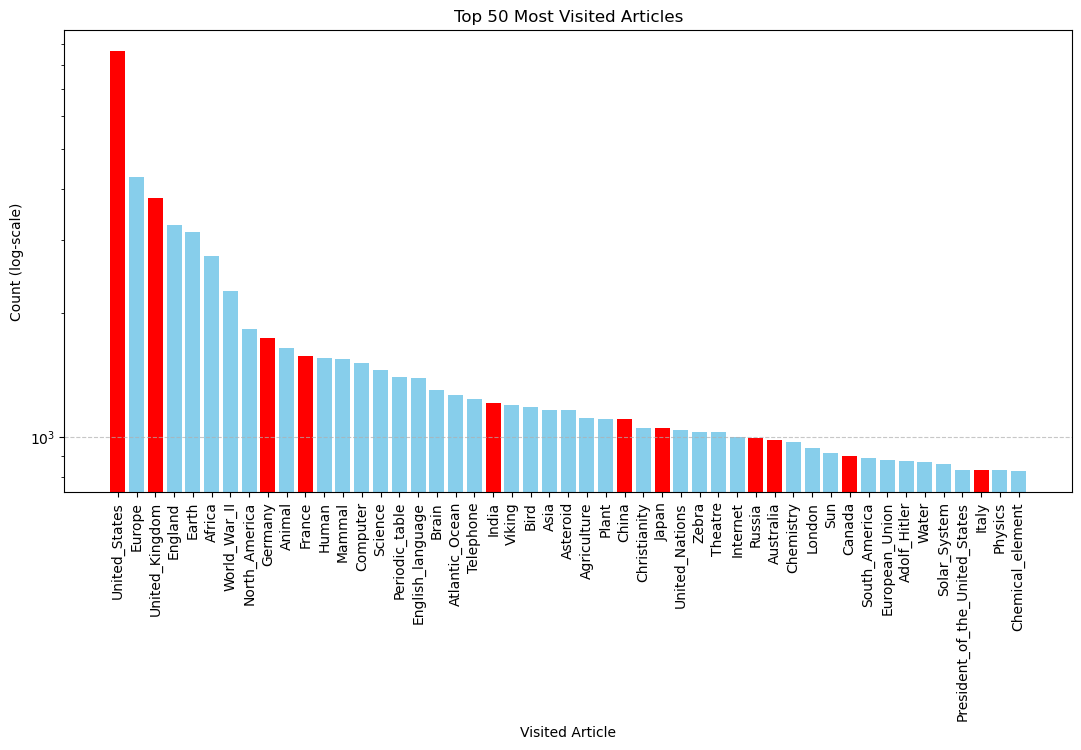

In [5]:
top_50_visited_articles(paths_finished, categories, show=True, html_file=True)

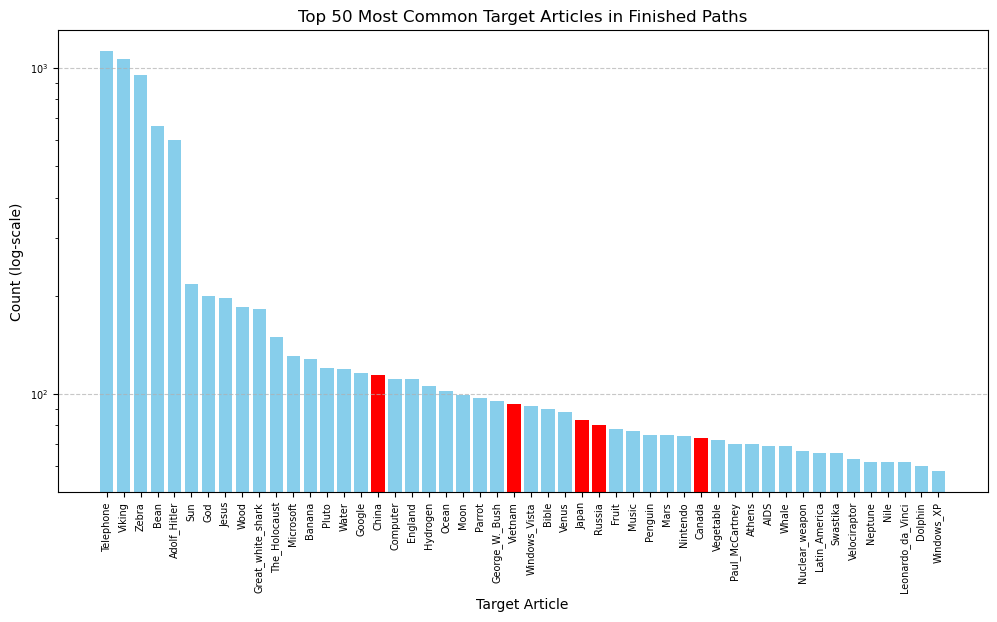

In [6]:
top_50_target_articles(paths_finished, categories, show=True)

We then look at the distribution of the length and duration of the finished paths to see if these correspond to a normal trend or if there are particular features to be analysed.

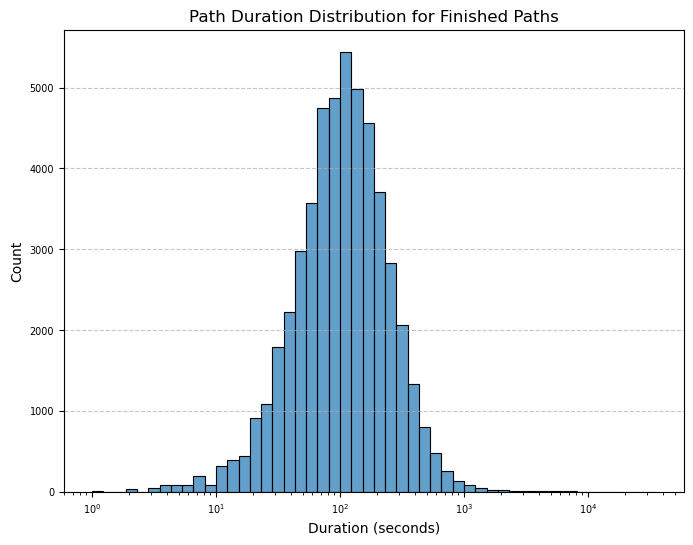

In [7]:
path_duration_distribution(paths_finished, show=True)

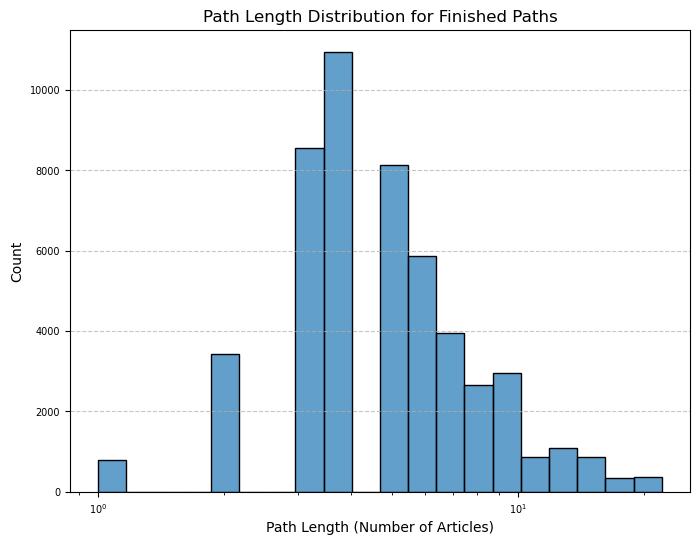

In [8]:
path_length_distribution(paths_finished, show=True)

Now that we've looked at distributions with a single valuer, we'll look at the links between several valuers: in particular, we'll look at the interaction between the length of the path and the length of the game's duration, and then the interaction between the score given to the chmin and its length.

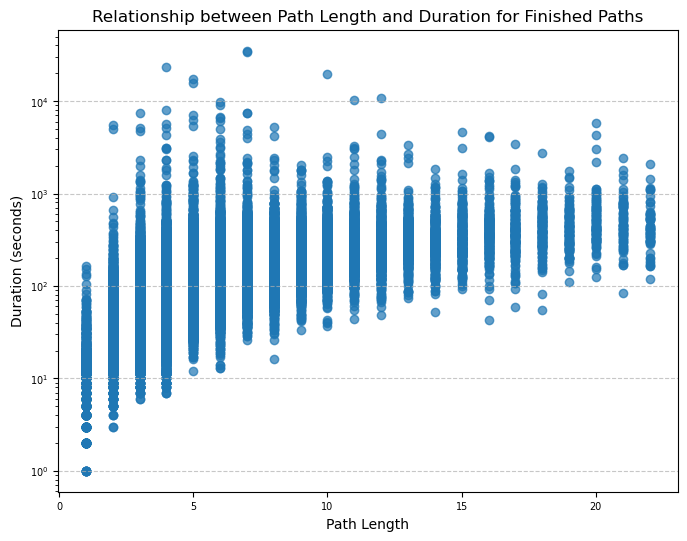

In [9]:
path_length_vs_duration(paths_finished, show=True)

<Figure size 1000x900 with 0 Axes>

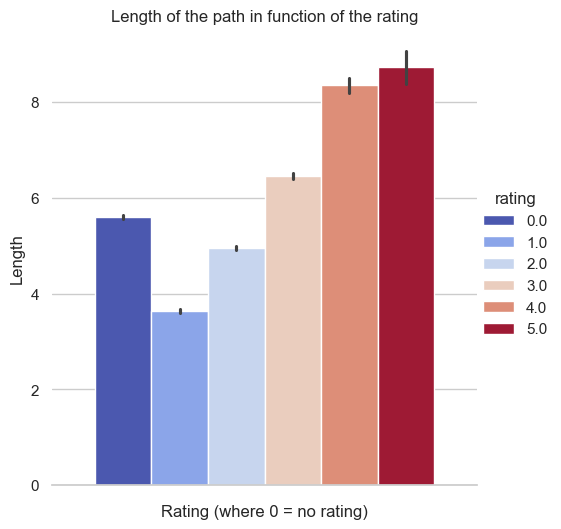

In [10]:
rating_vs_path_length(paths_finished, show=True)

Based on the previous two plots, we could hypothesize that the length of the path is correlated to the duration of the game and its rating, simply based on the apparent monotonicity of the data.
Both these interpretations are intuitive but we should perform a statistical regressions and tests to confirm them.

We may be interested in another more objective metrics. In other word, we try to compare how the difference between the actual path taken and the shortest (theoretical) path behaves with respect to the rating given.

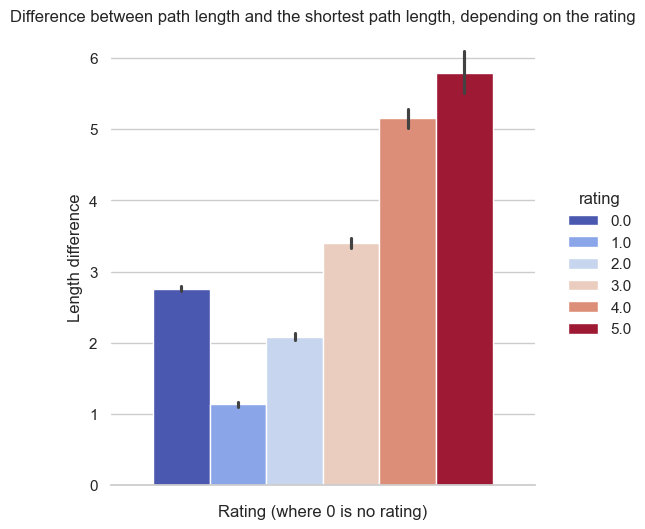

In [11]:
ax = sns.catplot(
    data=paths_finished,
    y="diff_length",
    kind="bar",
    palette="coolwarm",
    hue="rating",
)
ax.despine(left=True)
plt.title(
    "Difference between path length and the shortest path length, depending on the rating"
)
plt.xlabel("Rating (where 0 is no rating)")
plt.ylabel("Length difference")
plt.show()

Again, there seems to be some difference between the difference of length of paths for different ratings. Notice that compared to the path lengths for different rating, the difference between rating 4 vs 5 in more siginificant in the plot of difference in length. Indeed, the error bars do not overlap in these ratings.

For this reason, we will choose this difference between the path length and the shortest path length as our performance metric.

## Specific example: the United Kingdom

Now that we've looked at the data as a whole, let's take a closer look at one data set in particular, that of United Kingdom. This will allow us to define a set of snapshots for this particular area. We've decided to use United Kingdom as an example because it's one of the most visited items in the dataset and as one of our european neighbors, we can easily find clichés that are true.

In [12]:
main_article = "United_Kingdom"

In [13]:
count_in_out_neighbors(paths_finished, paths_unfinished, main_article)

Number of paths finished that contain United Kingdom: 3732
Number of paths unfinished that contain UnitedKingdom 1354
Number of paths that finished with United Kingdom: 28


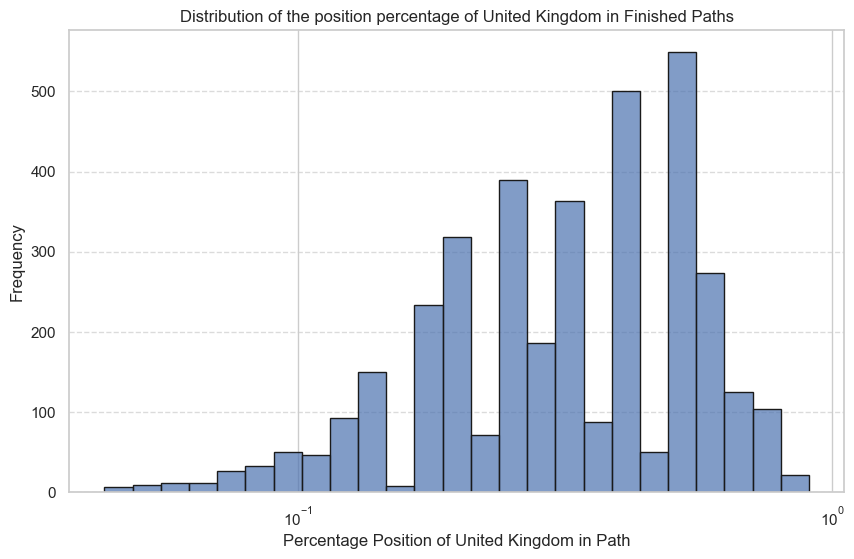

In [14]:
distribution_position_percentage(paths_finished, main_article, show=True)

In generality, we can't really infer any particular distribution from the data. However, in future analysis we could try to fit distributions when we consider the position of the main article conditonally on additional events (e.g. the path also contains a particular cliché).

In [15]:
# only keep rows such that main_article in path
around_main_article = get_df_main_article(
    paths_finished, main_article=main_article
).copy(deep=True)

# get category of the main_article
around_main_article["main_article_category"] = around_main_article["path"].apply(
    lambda path: get_category_main_article(main_article, path, categories)
)

# article juste before/just after main_article
# TODO: function to be improved/discussed. What do we want to do with "<"?
around_main_article["around_path"] = around_main_article["path"].apply(
    lambda path: get_index_main_article_in(main_article, path)
)

# update initial/target_article, initial/target_category
around_main_article["around_IA"] = around_main_article["around_path"].apply(
    lambda path: path[0]
)
around_main_article["around_TA"] = around_main_article["around_path"].apply(
    lambda path: path[-1]
)
around_main_article["around_IC"] = around_main_article["around_IA"].apply(
    lambda article: categories[categories["article"] == article]["category1"].values
)
around_main_article["around_TC"] = around_main_article["around_TA"].apply(
    lambda article: categories[categories["article"] == article]["category1"].values
)

around_main_article

,hashedIpAddress,timestamp,durationInSec,path,rating,path_length,shortest_path,diff_length,target_article,main_article_category,around_path,around_IA,around_TA,around_IC,around_TC
74,565e6dc60eeca66c,1253358736,77,"[Aberdeen, City_status_in_the_United_Kingdom, ...",0.0,5,3,2,Bread,[Geography],"[Aberdeen, City_status_in_the_United_Kingdom, ...",Aberdeen,Market,[Geography],[Business_Studies]
113,4dc8af51482ebb5a,1336876538,221,"[Achilles, Ethiopia, United_Kingdom, World_War...",3.0,4,2,2,Winston_Churchill,"[Countries, Geography, Geography]","[Ethiopia, United_Kingdom, World_War_II]",Ethiopia,World_War_II,"[Geography, Countries]",[History]
115,0adc390d00c8c538,1344743190,63,"[Achilles, Greek_mythology, Ancient_Greece, Eu...",3.0,6,2,4,Winston_Churchill,"[Countries, Geography, Geography]","[Europe, United_Kingdom, Prime_Minister_of_the...",Europe,Prime_Minister_of_the_United_Kingdom,[Geography],[Citizenship]
117,31980f901eee5467,1346717015,117,"[Achilles, Ethiopia, United_Kingdom, World_War...",0.0,4,2,2,Winston_Churchill,"[Countries, Geography, Geography]","[Ethiopia, United_Kingdom, World_War_II]",Ethiopia,World_War_II,"[Geography, Countries]",[History]
121,3a11233c52f824f8,1350896212,224,"[Achilles, William_Shakespeare, England, Great...",0.0,7,2,5,Winston_Churchill,"[Countries, Geography, Geography]","[<, United_Kingdom, World_War_II]",<,World_War_II,[],[History]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51280,6f4978c43a8faffd,1358871308,164,"[Timken_1111, Chicago, Roman_Catholic_Church, ...",0.0,5,4,1,British_monarchy,"[History, People]","[Industrial_Revolution, George_III_of_the_Unit...",Industrial_Revolution,British_monarchy,[History],[Citizenship]
51287,4e3201ac6a75f14f,1324457682,150,"[Tropical_Storm_Larry_(2003), Pacific_Ocean, U...",3.0,8,3,5,Magna_Carta,"[Countries, Geography, Geography]","[Pacific_Ocean, United_Kingdom, England]",Pacific_Ocean,England,[Geography],[Geography]
51299,3cc4f2837bf22048,1325177555,59,"[Union_Station_(San_Diego), World_War_II, Unit...",0.0,4,2,2,Bristol,"[Countries, Geography, Geography]","[World_War_II, United_Kingdom, England]",World_War_II,England,[History],[Geography]
51301,3278e904185ec5bc,1361584612,168,"[Valparaíso, World_Heritage_Site, Europe, <, U...",0.0,10,3,7,Hellenistic_Greece,"[Countries, Geography, Geography]","[<, United_Kingdom, United_Nations]",<,United_Nations,[],[Citizenship]


/Users/tudoroancea/Desktop/epfl/ma3/cs-401/ada-2023-project-abracadabra2023/part_2_exploratory_data_analysis.py:668: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




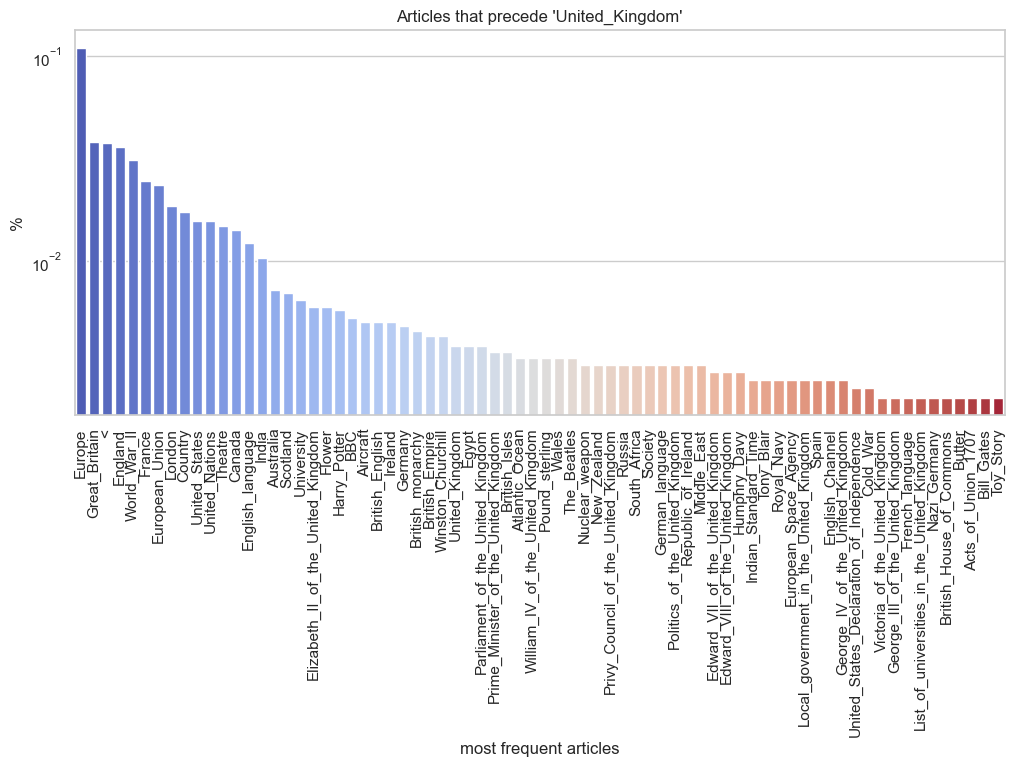

In [16]:
# keep only 10% most frequent articles just after main_article
most_frequent_before = around_main_article["around_IA"].value_counts(normalize=True)
plot_most_frequent_articles(most_frequent_before, "precede");

/Users/tudoroancea/Desktop/epfl/ma3/cs-401/ada-2023-project-abracadabra2023/part_2_exploratory_data_analysis.py:668: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




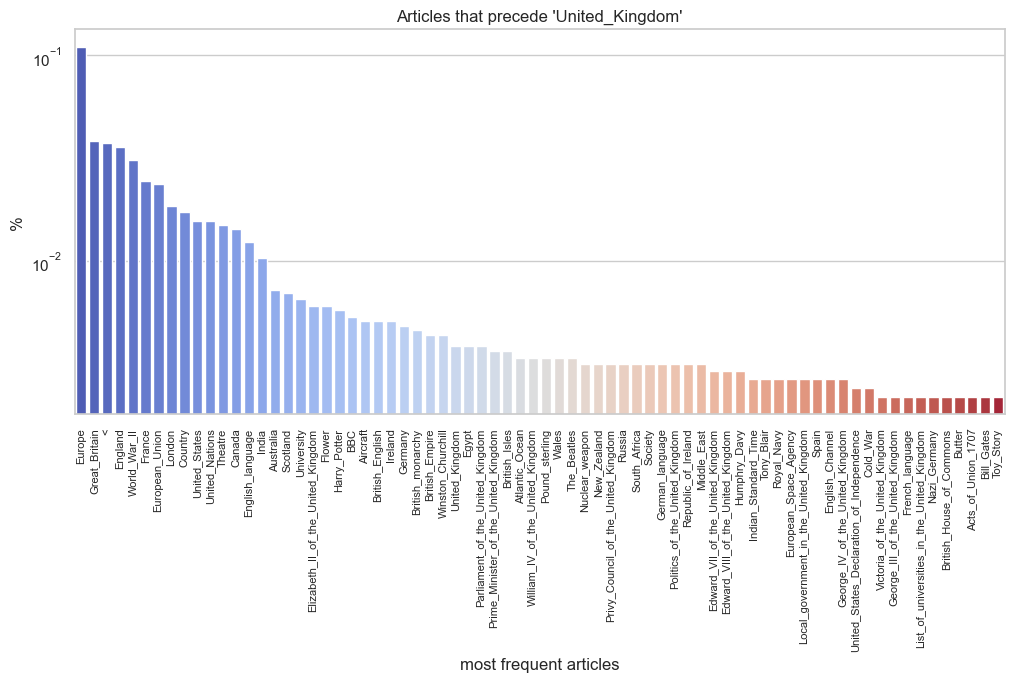

In [17]:
# keep only 10% most frequent articles just after main_article
most_frequent_before = around_main_article["around_IA"].value_counts(normalize=True)
plot_most_frequent_articles(most_frequent_before, "precede");

# Part 3: Preliminary cliché selection and analysis

## Cliches preprocessing

In this section we will define and extract data from the clichés. This will enable us to carry out analyses to discover whether or not there are any links between our chosen subject and the clichés.

## Statistical tests for difference of path length for different cliches

Now, we want to find some statistical evidence of whether clichés influence the length of the path from the initial article to the target article. From the previous exploration, it seems that the difference of path length between the actual path taken and the shortest (theoretical) path is a "good" metric of the player's performance.

So the idea is to select all the rows in `paths_finished` that contain the main article `United_Kingdom`. The selection of clichés remains to be done in an unbiased way. For now, we select "cliché" articles from the plots just above (see selected cliché articles below)[^1]. Next, it makes sense to compare difference in length for a given rating. Otherwise, as stated earlier, "harder" articles seem to tend to have higher difference in length and hence we would be comparing different categories.

To check whether there is a statistical difference, we compute a Welch's t-test. Indeed, given a rating, we assume that our observations are independant. Additionally, it seems that the difference in length among a rating between those who went through cliché articles and those who did not do not have same variance. 

[^1]: We are looking into different ways to retrieve cliché articles.

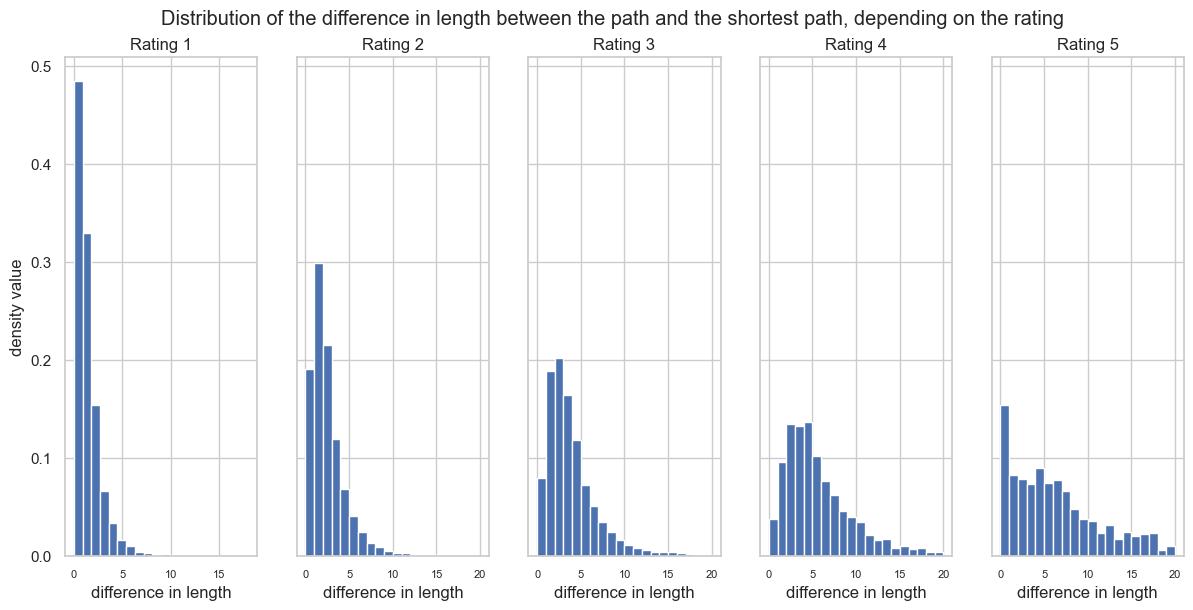

In [18]:
fig, axes = plt.subplots(1, 5, figsize=(12, 6), sharey=True)
fig.tight_layout()

for i, ax in enumerate(axes):
    temp = paths_finished[paths_finished["rating"] == i + 1]["diff_length"]
    ax.hist(temp, bins=20, density=True)
    ax.set_xlabel("difference in length")
    if i == 0:
        ax.set_ylabel("density value")
    ax.set_title(f"Rating {i+1}")

# make room for suptitle
fig.subplots_adjust(top=0.9)
fig.suptitle(
    "Distribution of the difference in length between the path and the shortest path, depending on the rating"
)

plt.show()

We observe that the higher the rating, the higher the variance. Additionally, it is worth noting that the data is imbalanced among the ratings.

Above, we have compared the variance between different ratings but not among a rating between the paths that go through cliché articles and those that do not. 

In [19]:
# select some cliches
main_article_cliches = [
    "William_Shakespeare",
    "Harry_Potter",
    "BBC",
    "Winston_Churchill",
    "The_Beatles",
    "Elizabeth_II_of_the_United_Kingdom",
    "Flower",
    "British_monarchy",
    "British_Empire",
    "Prime_Minister_of_the_United_Kingdom",
    "Pound_sterling",
    "London",
]

ratings = np.arange(1, 6, dtype=int)

In [20]:
# create dataframe
test_cliche = pd.DataFrame(
    columns=[
        "main_article",
        "cliche",
        "rating",
        "mean_cliche",
        "mean_nocliche",
        "shape_cliche",
        "shape_nocliche",
        "statistic",
        "p_value",
    ]
)

# test different ratings and cliches
for rating in ratings:
    for cliche in main_article_cliches:
        (
            stat,
            p,
            mean_path_cliche,
            mean_path_nocliche,
            shape_cliche,
            shape_nocliche,
        ) = test_difference_path_length_cliche(
            paths_finished, rating, cliche, main_article, False, False
        )
        test_cliche.loc[test_cliche.shape[0]] = [
            main_article,
            cliche,
            rating,
            mean_path_cliche,
            mean_path_nocliche,
            shape_cliche,
            shape_nocliche,
            stat,
            p,
        ]

test_cliche

/Users/tudoroancea/miniforge3/envs/ada/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1103: RuntimeWarning:

divide by zero encountered in divide

/Users/tudoroancea/miniforge3/envs/ada/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1103: RuntimeWarning:

invalid value encountered in scalar multiply

/Users/tudoroancea/miniforge3/envs/ada/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1103: RuntimeWarning:

divide by zero encountered in divide

/Users/tudoroancea/miniforge3/envs/ada/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1103: RuntimeWarning:

invalid value encountered in scalar multiply



,main_article,cliche,rating,mean_cliche,mean_nocliche,shape_cliche,shape_nocliche,statistic,p_value
0,United_Kingdom,William_Shakespeare,1,NaN,1.400332,"(0, 9)","(602, 9)",NaN,NaN
1,United_Kingdom,Harry_Potter,1,NaN,1.400332,"(0, 9)","(602, 9)",NaN,NaN
2,United_Kingdom,BBC,1,NaN,1.400332,"(0, 9)","(602, 9)",NaN,NaN
3,United_Kingdom,Winston_Churchill,1,NaN,1.400332,"(0, 9)","(602, 9)",NaN,NaN
4,United_Kingdom,The_Beatles,1,NaN,1.400332,"(0, 9)","(602, 9)",NaN,NaN
5,United_Kingdom,Elizabeth_II_of_the_United_Kingdom,1,NaN,1.400332,"(0, 9)","(602, 9)",NaN,NaN
6,United_Kingdom,Flower,1,NaN,1.400332,"(0, 9)","(602, 9)",NaN,NaN
7,United_Kingdom,British_monarchy,1,NaN,1.400332,"(0, 9)","(602, 9)",NaN,NaN
8,United_Kingdom,British_Empire,1,NaN,1.400332,"(0, 9)","(602, 9)",NaN,NaN
9,United_Kingdom,Prime_Minister_of_the_United_Kingdom,1,NaN,1.400332,"(0, 9)","(602, 9)",NaN,NaN


Note that in most cases, we do not have enough data to compare. However, those going through the article `London` are *almost* statistically significantly (at $\alpha=0.05$) more performant that others fore rating 1 and 2.

## Categories and clichés

We consider here the finished paths passing through our chosen main article "United_Kingdom".
We enumerate all the categories of the articles at most 3 steps away from the main article on these paths and construct a bar chart to visualize their number of occurences.
We further color each category bar depending on whether "United_Kingdom" belongs to it or not.
Finally, arrows are used to indicate specific categories of a given cliché (here “William_Shakespeare”, drawn from the list created in the previous section). 

In [21]:
all_categories, subcategories1, subcategories2, subcatgeories3 = separate_categories(
    main_article, categories
)

Non-coincide Categories at 1 step away from UK: [('United_Kingdom', 'African_Countries'), ('United_Kingdom', 'History'), ('United_Kingdom', 'British_History'), ('United_Kingdom', 'British_History_Post_1900'), ('United_Kingdom', 'Citizenship'), ('United_Kingdom', 'Politics_and_government'), ('United_Kingdom', 'African_Geography'), ('United_Kingdom', 'African_Countries'), ('United_Kingdom', 'History')]
Non-coincide Categories at 2 steps away from UK: [('United_Kingdom', 'Ancient_History_Classical_History_and_Mythology'), ('United_Kingdom', 'African_Geography'), ('United_Kingdom', 'African_Countries'), ('United_Kingdom', 'History'), ('United_Kingdom', 'British_History'), ('United_Kingdom', 'British_History_Post_1900'), ('United_Kingdom', 'History'), ('United_Kingdom', 'British_History'), ('United_Kingdom', 'British_History_Post_1900')]
Non-coincide Categories at 3 steps away from UK: [('United_Kingdom', 'Ancient_History_Classical_History_and_Mythology'), ('United_Kingdom', 'African_Geogra

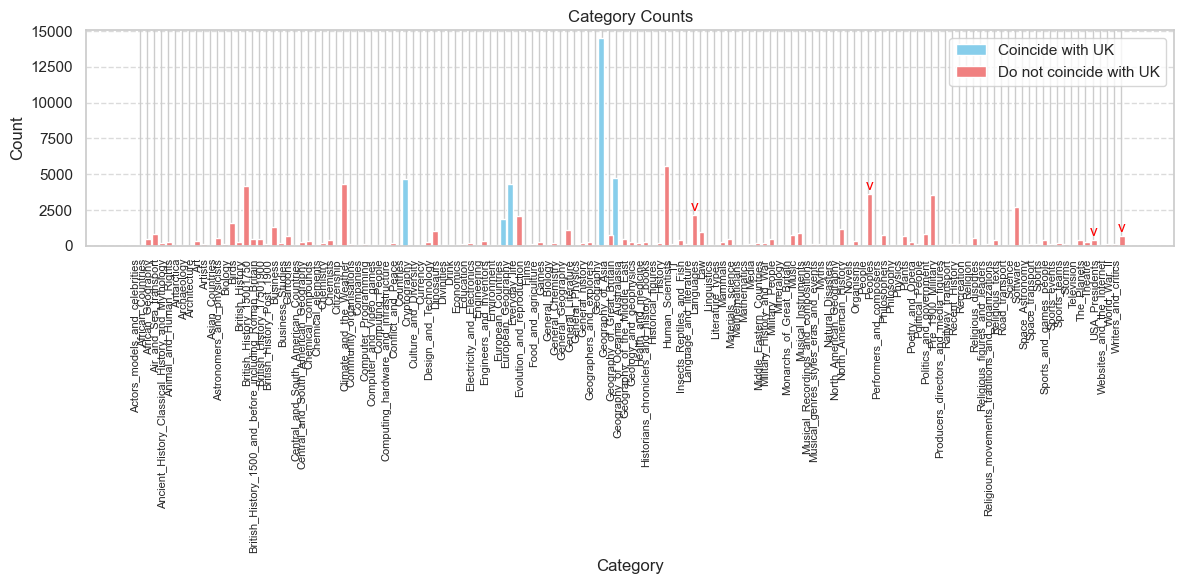

In [22]:
combine_results(
    paths_finished,
    main_article,
    categories,
    all_categories,
    ["category1", "category2", "category3"],
)

This bar plot shows that:
- the categories that "United_Kingdom" belongs to are (among) the most frequent ones, which is not surprising given that the hyperlinks in an article should redirect to related articles, and given that the players often rely on semantic links to find the target article.
- if we look at the categories of our designated cliché "William_Shakespeare", they are quite frequent, although not coinciding with the "United_Kingdom"'s catgeories. This is not surprising either, because of the very nature of the two articles: one of them is a country, the other one is a playwright. However, we can see that the categories of "William_Shakespeare" are quite frequent, which is a good sign for our project.

# Part 4: Advanced cliché selection (data augmentation pipeline)

As seen previously, we do not have much data to extract meaningful results. So, we may want to augment our data.

The pipeline for augmenting our data is the following: we analyze the clichés around the UK in the SeeGull data set as well as the content of the articles and try to link them together. More precisely, we retreive the "topics" of the clichés from the SeeGull data set (eg alcohol, liquid etc.) and do the same for each articles.

So far, we have two sets of topics: one from the SeeGull dataset, and one for each article from the main data base. We add article to our list of cliché articles if there are "enough" topics in common.

The main part of this analysis is to make sure that is pipeline is sensible:
- does is make sense to compare the two sets of topics? 
- does it actually augment the data (statistical significance for the t-tests above)

**To help us a bit to visualise what might be clichés about UK:**
    
Prompt ChatGPT: give me clichés about the UK using bullet points and at most 5 words by cliché
- Tea time obsession
- Polite queueing traditions
- Rainy weather stereotypes
- Double-decker buses iconic
- Sherlock Holmes detective legacy
- Royal family fascination
- Soccer (football) mania
- Pubs and fish & chips
- Mysterious foggy landscapes
- Love for proper etiquette
- Red phone booths everywhere
- Beatles' timeless musical influence

## Topics

### SeeGull topics

In [24]:
uk_topics_seegull = generate_seegull_topics(["British", "English"], 10)

attributes of UK:
  arrogant arrogant domineer cowardly bad teeth snob conceited snooty bad teeth snobby uncontrolled cold stiff upper lip aristocratic pompous refine tea drinking annoyed tea country theory good swimmer uncertain stiff upper lip good making tea british pompous understated tea queen stuck multiracial stuffy vapid labour trendy fantastic chess fussy multifaith genero self deprecate sophisticated sophisticated stiff imperialist stiff self indulgent proper superior direct proper love tea civilize forward elegant drink tea culture reserve polite good cricket fair intelligent practical brave red word aloof cat parochial generous polite drink tea intelligent love tea superior refine witty hardworking tasteful civilize progress self control reserve unyielding fair honourable practical shy clever bore aloof considerate brave sociable progressive generous warmth courageous expect kind art travel eat lot colour bought outgo affectionate

main topics:
liquid               7.874%
b

### Wikispeedia dataset topics

We have seen above common generated around the word 'British' and 'English'. Now we would like to see if we could look at the topics of our articles compared to the of the United_Kingdom. We first generate the topics for all the articles. 

In [25]:
article_topics = load_articles_topics()

Before doing the comparison for all articles, let's first check the result with 10 random articles compared to United_Kingdom.

In [26]:
np.random.seed(16)

uk_topics_row = article_topics[article_topics["article_name"] == "United_Kingdom"]
# Randomly select 10 articles
random_articles = article_topics.sample(n=10)

for index, row in random_articles.iterrows():
    common_topics = set(row["topics"]) & set(uk_topics_row["topics"].values[0])
    print(
        f"Common topics for {row['article_name']} and United Kingdom: {common_topics}"
    )

Common topics for 55_Cancri_e and United Kingdom: {'money', 'wedding', 'dance', 'help', 'office'}
Common topics for Glaciology and United Kingdom: {'money', 'wedding', 'dance', 'help', 'office'}
Common topics for Common_Tern and United Kingdom: {'money', 'wedding', 'dance', 'help', 'office'}
Common topics for Pope_John_Paul_II and United Kingdom: {'money', 'wedding', 'dance', 'help', 'office'}
Common topics for 11th_century and United Kingdom: {'money', 'wedding', 'dance', 'help', 'office'}
Common topics for Herbig-Haro_object and United Kingdom: {'money', 'wedding', 'dance', 'help', 'office'}
Common topics for Microsoft and United Kingdom: {'money', 'office'}
Common topics for Hovercraft and United Kingdom: {'office', 'help'}
Common topics for Culture and United Kingdom: {'government'}
Common topics for Neptune and United Kingdom: {'money', 'wedding', 'dance', 'help', 'office'}


Topics seem to revolve around general topics. But we have here articles that do not seem linked to United_Kingdom and thus we cannot really conclude something with this result. We thus compare all articles to have a greater batch for analysis. 

In [27]:
uk_topics = uk_topics_row.iloc[0]["topics"]

# Compare topics for all articles in the dataset
common_article_topics = []

for index, row in article_topics.iterrows():
    if row["article_name"] == main_article:
        continue
    common_topics = set(row["topics"]) & set(uk_topics_row["topics"].values[0])
    if common_topics:
        common_article_topics.append(
            {"article_name": row["article_name"], "common_topics": common_topics}
        )

# Sort comparisons based on the number of common topics
common_article_topics.sort(key=lambda x: len(x["common_topics"]), reverse=True)

common_article_topics = pd.DataFrame(common_article_topics)
display(common_article_topics.head(20))

,article_name,common_topics
0,William_Renshaw,"{government, money, dance, power, help, weddin..."
1,12th_century,"{money, dance, wedding, power, help, office, m..."
2,13th_century,"{government, money, wedding, dance, help, offi..."
3,14th_century,"{government, money, wedding, dance, help, offi..."
4,16th_century,"{money, dance, wedding, power, help, office, m..."
5,2nd_century,"{money, dance, power, help, office, medieval, ..."
6,3rd_century,"{money, dance, wedding, power, help, office, m..."
7,6th_century,"{money, dance, wedding, power, help, office, m..."
8,Addis_Ababa,"{money, dance, power, help, office, medieval, ..."
9,Akkadian_Empire,"{government, money, dance, power, help, office..."


We notice that the common topics are very general and a lot of articles have them. So we need to filter the content of the articles. Here below, we can have a better view of the result with three random articles displayed. 


In [28]:
# extract the common topics for articles 12th_century, Armand_Jean_du_Plessis%2C_Cardinal_Richelieu, Babylonia
concrete_examples = common_article_topics[
    common_article_topics["article_name"].isin(
        ["12th_century", "Armand_Jean_du_Plessis%2C_Cardinal_Richelieu", "Babylonia"]
    )
]
for _, row in concrete_examples.iterrows():
    print(f"{row['article_name']} and United Kingdom: {row['common_topics']}")
concrete_examples.to_html(
    "random_common_topics.html", index=False, justify="justify", border=3
)

12th_century and United Kingdom: {'money', 'dance', 'wedding', 'power', 'help', 'office', 'medieval', 'royalty'}
Armand_Jean_du_Plessis%2C_Cardinal_Richelieu and United Kingdom: {'money', 'dance', 'wedding', 'power', 'help', 'office', 'medieval', 'royalty'}
Babylonia and United Kingdom: {'money', 'dance', 'wedding', 'power', 'help', 'office', 'medieval', 'royalty'}


## Proper nouns
As the previous analysis over topics did not give us meaningful material to work with, we now look at a different way to compare the articles: look at the most proper nouns in the texts.

In [29]:
# Load the preprocessed data
tokens_and_pos = load_token_pos()

# Filter rows related to the target article
target_article_data = tokens_and_pos[tokens_and_pos["article_name"] == main_article]

# Extract the top 10 PROPN tokens for the target article
target_proper_nouns = [
    token[0]
    for tokens_pos_list in target_article_data["tokens_pos"]
    for token in tokens_pos_list
    if token[1] == "PROPN"
]
top_target_proper_nouns = [
    item[0] for item in Counter(target_proper_nouns).most_common(10)
]

# Initialize a list to store common proper nouns
common_proper_nouns = []

# Iterate through each row in the DataFrame
for index, row in tokens_and_pos.iterrows():
    # Extract the top 10 PROPN tokens for each article
    if row["article_name"] == main_article:
        continue
    article_proper_nouns = [
        token[0] for token in row["tokens_pos"] if token[1] == "PROPN"
    ]
    top_article_proper_nouns = [
        item[0] for item in Counter(article_proper_nouns).most_common(10)
    ]

    # Compare with the top PROPN tokens of the target article
    common_tokens = set(top_article_proper_nouns) & set(top_target_proper_nouns)

    # Store the results
    common_proper_nouns.append(
        {"article_name": row["article_name"], "common_propnouns": common_tokens}
    )

# Convert the results to a DataFrame
common_proper_nouns_df = pd.DataFrame(common_proper_nouns)

# Sort the DataFrame based on the number of common proper nouns
common_proper_nouns_df = common_proper_nouns_df.sort_values(
    by="common_propnouns", key=lambda x: x.str.len(), ascending=False
)

# Print the top 5 comparisons
print("Top 5 comparisons with most common proper nouns:")
for i in range(min(5, len(common_proper_nouns_df))):
    print(
        f"{common_proper_nouns_df.iloc[i]['article_name']} and {main_article}: {common_proper_nouns_df.iloc[i]['common_propnouns']}"
    )

# Save the top comparisons to a CSV file
top_comparisons = common_proper_nouns_df.head(50)

Top 5 comparisons with most common proper nouns:
United_Kingdom_national_football_team and United_Kingdom: {'UK', 'Scotland', 'Northern', 'Kingdom', 'Ireland', 'England', 'United'}
Pound_sterling and United_Kingdom: {'UK', 'Scotland', 'Northern', 'Kingdom', 'Ireland', 'England', 'United'}
Great_Britain and United_Kingdom: {'Scotland', 'Northern', 'Kingdom', 'Ireland', 'England', 'British', 'United'}
England and United_Kingdom: {'UK', 'Scotland', 'Kingdom', 'London', 'England', 'United'}
British_Isles and United_Kingdom: {'Scotland', 'Kingdom', 'Ireland', 'England', 'British', 'United'}


This top 5 already gives us some hope! All articles are indeed related to the United_Kindom. However, when loking at the proper noun in common, we mostly see locations. This might give us clichés only revolving on geographical links. 

In [30]:
common_proper_nouns_df.head(5).to_html("common_proper_nouns.html", index=False)

### Links

We have still not looked at hyperlinks, which are the most relevant considering the game we are working with. The idea is to compare the `linkTarget` in the reference article (UK) and other articles. Articles that are greatly connected to United_Kingdom are selected as clichés articles.

We first load the data containing the hyperlinks.

In [31]:
# load the precomputed data
# links by article in common with the main/reference article
links_common = load_links_common()
links_common.head(20)

,article_name,common_links
0,Áedán_mac_Gabráin,"[Orkney, Isle_of_Man, Monarchy, Great_Britain,..."
1,Åland,"[Time_zone, World_War_II, Currency, European_U..."
2,Édouard_Manet,"[Germany, United_States_dollar, Italy, France]"
3,Éire,"[English_language, Ireland, Republic_of_Irelan..."
4,Óengus_I_of_the_Picts,"[Lion, Great_Britain, Ireland, Scotland, England]"
5,€2_commemorative_coins,"[United_Nations, Ireland, Italy, European_Unio..."
6,10th_century,"[Lion, Monarchy, Italy, India, Scotland, Germa..."
7,11th_century,"[England, France, India, Novel]"
8,12th_century,"[England, Ireland, France, India]"
9,13th_century,"[Europe, Islam, Scotland, Isle_of_Man]"


As done previously, we first look at a small set for the comparison to see whether it may show some interesting result. 

In [32]:
# find 3 random sampes
random_samples = links_common.sample(n=3)
for _, row in random_samples.iterrows():
    print(
        f"Common links between {row['article_name']} and United Kingdom: {row['common_links']}"
    )
random_samples.to_html("random_common_links.html", index=False)

Common links between Francis_Bacon and United Kingdom: ['University_of_Cambridge', 'London', 'France', 'Wales', 'England']
Common links between Bluetooth and United Kingdom: ['University_of_Cambridge', 'Computer']
Common links between Ethiopian_Wolf and United Kingdom: []


We then proceed to do it for all articles and print the top 20.

In [33]:
links_common["nbr_common_links"] = links_common["common_links"].apply(len)
links_common.sort_values("nbr_common_links", ascending=False, inplace=True)
links_common.head(20)

,article_name,common_links,nbr_common_links
1379,England,"[Industrial_Revolution, Benjamin_Britten, Engl...",63
3642,Scotland,"[Industrial_Revolution, Parliament_of_the_Unit...",57
4282,United_States,"[Natural_gas, World_War_II, NATO, World_Herita...",42
700,British_monarchy,"[Parliament_of_the_United_Kingdom, World_War_I...",35
2530,London,"[Parliament_of_the_United_Kingdom, World_War_I...",33
1360,Elizabeth_II_of_the_United_Kingdom,"[British_monarchy, World_War_II, Northern_Irel...",32
698,British_Isles_(terminology),"[Scottish_Gaelic_language, Northern_Ireland, A...",32
1427,Europe,"[Industrial_Revolution, World_War_II, NATO, No...",32
1383,English_language,"[World_War_II, Northern_Ireland, Jersey, Briti...",30
1688,Germany,"[Natural_gas, Industrial_Revolution, World_War...",29


Lots of locations appear. We may want to remove them.

# Part 5: Final statistical tests

 However, if we proceed by comparing links, we could penalize articles that are 'short' or do not include many hyperlinks. That's why we've decided to normalize the number of links: instead of using a whole number, we're working with the percentage of an article's links (in relation to its total number of hyperlinks) that are linked to our article of interest.


### Normalize number of links in common

In [34]:
# find number of links by article

# linkSource in the article considered
# linkTarget are the links the article points to
df_nbr_links_by_articles = pd.pivot_table(
    links, values=["linkTarget"], index=["linkSource"], aggfunc="count"
).sort_values("linkTarget")
display(df_nbr_links_by_articles)

,linkTarget
linkSource,
Soil_structure,1
T._D._Judah,1
Pere_Marquette_1225,1
Friend_Directdebit,1
Animal_law,1
...,...
List_of_sovereign_states,216
List_of_circulating_currencies,236
List_of_countries,244


In [35]:
# only keep articles with at least one in common
# we are not interested in articles that have no relation (in "links term")
# to our main article
no_zero_common_articles = links_common[
    ~np.where(links_common["nbr_common_links"] == 0, True, False)
].sort_values("nbr_common_links", ascending=False)
display(no_zero_common_articles)

,article_name,common_links,nbr_common_links
1379,England,"[Industrial_Revolution, Benjamin_Britten, Engl...",63
3642,Scotland,"[Industrial_Revolution, Parliament_of_the_Unit...",57
4282,United_States,"[Natural_gas, World_War_II, NATO, World_Herita...",42
700,British_monarchy,"[Parliament_of_the_United_Kingdom, World_War_I...",35
2530,London,"[Parliament_of_the_United_Kingdom, World_War_I...",33
...,...,...,...
489,Batman,[Scotland],1
510,Battle_of_Smolensk_(1943),[World_War_II],1
508,Battle_of_Rennell_Island,[World_War_II],1
506,Battle_of_Moscow,[World_War_II],1


In [36]:
no_zero_common_articles_normalized_links = no_zero_common_articles.copy(deep=True)


def normalize_links(article, size_common_links, size_total_links):
    # normalize number of links in common by number of links in article
    total_links_article = size_total_links.loc[article].values[0]
    return size_common_links / total_links_article


# normalize number of links in common by number of links in article considered
no_zero_common_articles_normalized_links["normalized_common"] = no_zero_common_articles[
    ["article_name", "nbr_common_links"]
].apply(
    lambda row: normalize_links(
        row["article_name"], row["nbr_common_links"], df_nbr_links_by_articles
    ),
    axis=1,
)

display(
    no_zero_common_articles_normalized_links.sort_values(
        "normalized_common", ascending=False
    ).head(10)
)

# number of articles that have at least one link in common with UK
print(no_zero_common_articles_normalized_links.shape)

,article_name,common_links,nbr_common_links,normalized_common
840,Celtic_Park,"[London, Cardiff, Celtic_F.C., Scotland, Footb...",6,1.000000
2636,Marc_Pugh,"[Football_(soccer), England]",2,1.000000
1367,Emma_Roberts,[Canada],1,1.000000
2020,Human_abdomen,[Latin],1,1.000000
1633,Garden_Gnome_Liberation_Front,"[Italy, France]",2,1.000000
3969,T._D._Judah,[Canada],1,1.000000
115,Acts_of_Union_1707,"[Pound_sterling, Edinburgh, Laws_in_Wales_Acts...",6,0.857143
2288,Jordanhill_railway_station,"[Pound_sterling, United_States_dollar, Cricket...",5,0.833333
4164,Tottenham_Hotspur_F.C.,"[London, World_War_II, Arsenal_F.C., Mancheste...",10,0.769231
3689,Severn_crossing,"[London, England, Wales]",3,0.750000


(3879, 4)


As we can see, some articles have a perfect score (1). But the number of links in common with *United_Kingdom* is very low for these. Hence, it is difficult to say whether it is good representation of the clichés around the UK. Indeed, subjects like "Acts of Union 1707" are indeed related to the UK but are arguably not considered as clichés. In this sense, we have decided not to consider normalizing the number of links and stay in absolute values.

### Perform the statistical tests

As stated above, we forget normalization. Now, we do similar statistical analysis as earlier using data augmentation.

In [37]:
# re-sort commom links by the number of links in common (absolute value)
common_articles_normalized = (
    no_zero_common_articles_normalized_links.sort_values(
        "nbr_common_links", ascending=False
    )
    .reset_index(drop=True)
    .copy(deep=True)
)
common_articles_normalized.head(20)

,article_name,common_links,nbr_common_links,normalized_common
0,England,"[Industrial_Revolution, Benjamin_Britten, Engl...",63,0.366279
1,Scotland,"[Industrial_Revolution, Parliament_of_the_Unit...",57,0.508929
2,United_States,"[Natural_gas, World_War_II, NATO, World_Herita...",42,0.142857
3,British_monarchy,"[Parliament_of_the_United_Kingdom, World_War_I...",35,0.309735
4,London,"[Parliament_of_the_United_Kingdom, World_War_I...",33,0.323529
5,Elizabeth_II_of_the_United_Kingdom,"[British_monarchy, World_War_II, Northern_Irel...",32,0.320000
6,British_Isles_(terminology),"[Scottish_Gaelic_language, Northern_Ireland, A...",32,0.533333
7,Europe,"[Industrial_Revolution, World_War_II, NATO, No...",32,0.201258
8,English_language,"[World_War_II, Northern_Ireland, Jersey, Briti...",30,0.254237
9,British_Empire,"[Industrial_Revolution, World_War_II, English_...",29,0.224806


Visualisation of the articles that have the most links in common.

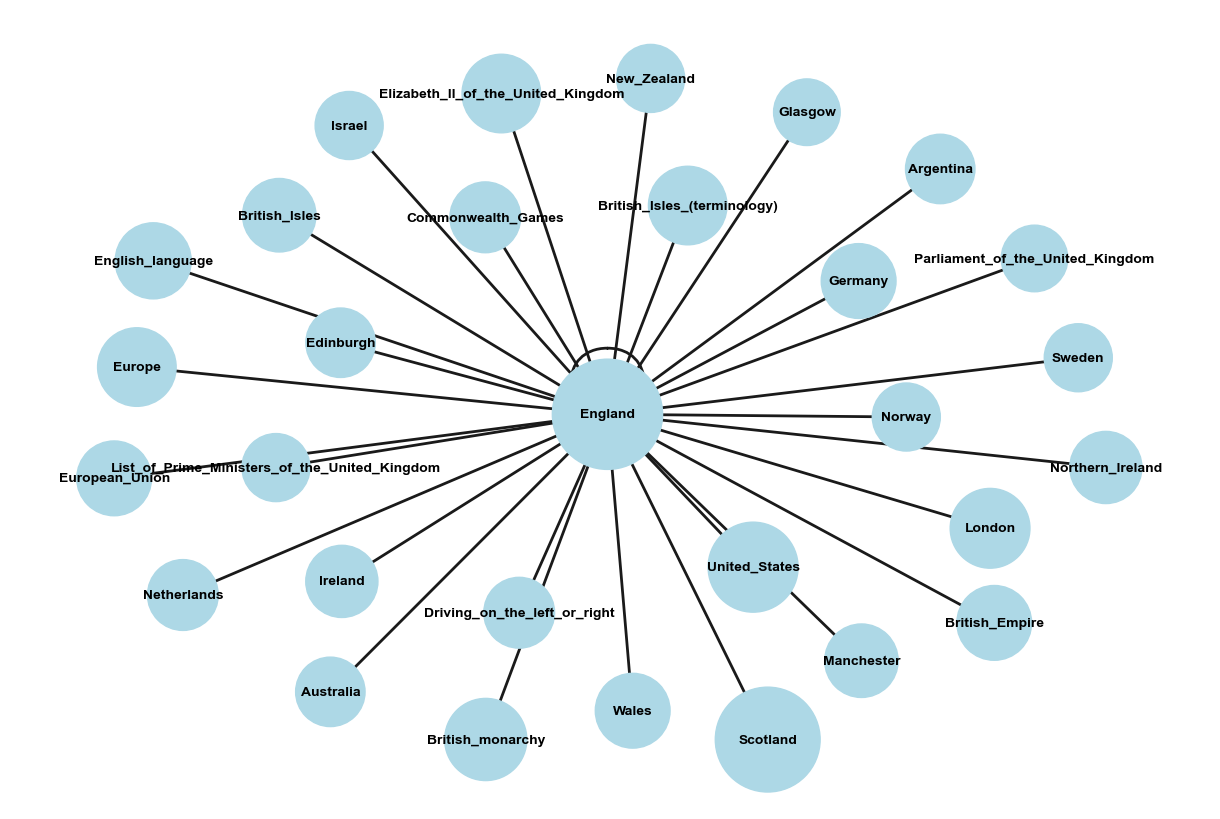

In [38]:
# we use networkx package
def draw_graph(df):
    G = nx.Graph()

    # center node is main article 
    # its weights is the number of links it has
    center_node = df["article_name"][0]
    G.add_node(center_node, weight=df["nbr_common_links"][0])

    # add other nodes and edges (articles)
    for i, node in enumerate(df["article_name"]):
        G.add_node(df["article_name"][i], weight=df["nbr_common_links"][i])
        G.add_edge(center_node, node, weight=2)

    return G

# create graph on common articles
weighted_star = draw_graph(common_articles_normalized[:30])

# get noe weights and edges
node_weights = [weighted_star.nodes[node]['weight'] for node in weighted_star.nodes]
edge_weights = [weighted_star.edges[edge]['weight'] for edge in weighted_star.edges]

# size of node proportional to the number of links
node_size = [100 * weight for weight in node_weights]

# set edge width
edge_width = [weight for weight in edge_weights]

# draw the graph
plt.figure(figsize=(12,8))
pos = nx.spring_layout(weighted_star)
nx.draw(weighted_star, pos, with_labels=True, font_weight='bold', node_size=node_size, node_color='lightblue', font_size=10, font_color='black', width=edge_width)

plt.show()


As visible in the above graph, there a lot of locations/geographical articles. This comes from the fact that geography is a strong bind in history. But in our case, including countries may include too many cliché articles for our data augmentation. So we filter them out.

In [39]:
def get_locations(s: pd.Series, criteria: str = ["GPE", "LOC"]):
    """
    find locations in a given pandas serie.
    input:
        s: pandas series, each element is a list or a string
        criteria: get elements that are locations
    return:
        unique_location: locations in s
    """
    # get list of links in common
    if isinstance(s.values[0], list):
        set_common = set(
            [item for sublist_articles in s.values for item in sublist_articles]
        )
    else:
        set_common = set(s.values)

    # define reference text
    text_reference = " ".join(set_common)

    # create nlp object
    nlp = spacy.load("en_core_web_sm")
    doc = nlp(text_reference)

    # extract countries and cities
    locations = [(ent.text, ent.label_) for ent in doc.ents if ent.label_ in criteria]

    # filter out duplicates
    unique_locations = set([loc[0] for loc in locations])

    return unique_locations


# countries in links in common
common_articles_country = get_locations(common_articles_normalized["common_links"])

# countries in articles (that have at least one link in common)
articles_country = get_locations(common_articles_normalized["article_name"])

In [40]:
# list of countries in common articles and in article names
display(common_articles_country, articles_country)

{'Canada',
 'Edinburgh',
 'England',
 'France',
 'Islam',
 'London',
 'Manchester_United_F.C.',
 'Market Europe',
 'Monarchy',
 'Pakistan',
 'Spain'}

{'1_Ceres',
 'Afghanistan',
 'Akira_Kurosawa',
 'Albania',
 'Algeria',
 'Alpaca',
 'Amsterdam',
 'Angola',
 'Antarctica',
 'Atlanta,_Georgia',
 'Australia',
 'BP',
 'Babur',
 'Babylonia',
 'Bangkok',
 'Barcelona',
 'Barium',
 'Basel',
 'Battle_of_Austerlitz',
 'Battle_of_Midway',
 'Belarus',
 'Belgium',
 'Benjamin_Franklin',
 'Benjamin_of_Tudela',
 'Birmingham',
 'Blue_Wildebeest York',
 'Booby Beach',
 'Brazil',
 'Brussels',
 'Bulgaria',
 'Cairo',
 'Cambodia',
 'Cambridge',
 'Canada',
 'Canterbury',
 'Caracas',
 'Caratacus',
 'Chad',
 'Chicago',
 'China',
 'Dada',
 'Damascus',
 'Dresden',
 'Earth',
 'Ecuador',
 'England',
 'Federated_States_of_Micronesia',
 'Finland',
 'Florida',
 'Francisco_Goya',
 'Frankfurt',
 'Ghana',
 'Gothenburg',
 'Greece',
 'Guinea',
 'Gulf_of_Mexico',
 'Haiti',
 'Hamburg',
 'Hanoi',
 'Hawfinch',
 'History_of_Arizona',
 'History_of_New_Jersey City',
 'History_of_Puerto_Rico',
 'Honduras',
 'Hubble_Deep_Field',
 'India',
 'Indonesia',
 'Iraq',
 'Ireland',
 'Ist

In [41]:
# define the clichés
limit_articles = 50
set_cliches = set(common_articles_normalized["article_name"][:limit_articles]).difference(
    articles_country.union(common_articles_country)
)
print(f"Number of cliches: {len(set_cliches)}")
set_cliches

Number of cliches: 36


{'Argentina',
 'Bath,_Somerset',
 'Bristol',
 'British_Empire',
 'British_Indian_Ocean_Territory',
 'British_Isles',
 'British_Isles_(terminology)',
 'British_monarchy',
 'Commonwealth_Games',
 'Denmark',
 'Driving_on_the_left_or_right',
 'Elizabeth_II_of_the_United_Kingdom',
 'Elizabeth_I_of_England',
 'English_language',
 'Europe',
 'European_Union',
 'Falkland_Islands',
 'Germany',
 'Glasgow',
 'History_of_the_world',
 'Isle_of_Man',
 'Israel',
 'Lebanon',
 'Liechtenstein',
 'List_of_Prime_Ministers_of_the_United_Kingdom',
 'List_of_circulating_currencies',
 'Luxembourg',
 'Manchester',
 'New_Zealand',
 'Northern_Ireland',
 'Olympic_Games',
 'Parliament_of_the_United_Kingdom',
 'Republic_of_Ireland',
 'Romania',
 'Tony_Blair',
 'United_States'}

We compute those that go through at least one cliché in the column `uses_cliche`.

In [42]:
paths_finished_use_cliche = paths_finished.copy(deep=True)


# check which paths use cliches
def common_articles(path, set_cliches):
    common_set = set(path) & set_cliches
    return len(common_set) != 0, common_set


paths_finished_use_cliche["uses_cliche"] = paths_finished["path"].apply(
    lambda path: len(set(path) & set_cliches) != 0
)
paths_finished_use_cliche

,hashedIpAddress,timestamp,durationInSec,path,rating,path_length,shortest_path,diff_length,target_article,uses_cliche
0,6a3701d319fc3754,1297740409,166,"[14th_century, 15th_century, 16th_century, Pac...",0.0,8,3,5,African_slave_trade,False
1,3824310e536af032,1344753412,88,"[14th_century, Europe, Africa, Atlantic_slave_...",3.0,4,3,1,African_slave_trade,True
2,415612e93584d30e,1349298640,138,"[14th_century, Niger, Nigeria, British_Empire,...",0.0,7,3,4,African_slave_trade,True
3,64dd5cd342e3780c,1265613925,37,"[14th_century, Renaissance, Ancient_Greece, Gr...",0.0,3,2,1,Greece,False
4,015245d773376aab,1366730828,175,"[14th_century, Italy, Roman_Catholic_Church, H...",3.0,6,3,3,John_F._Kennedy,False
...,...,...,...,...,...,...,...,...,...,...
51313,15a13a1d66ef5456,1349231015,66,"[Yagan, Ancient_Egypt, Civilization]",0.0,2,2,0,Civilization,False
51314,2ef7ac844cefda58,1300254138,165,"[Yagan, Folklore, Brothers_Grimm, <, 19th_cent...",3.0,8,3,5,Fiction,False
51315,12863abb7887f890,1385095372,228,"[Yagan, Australia, England, France, United_Sta...",0.0,6,3,3,U.S._Open_(tennis),True
51316,19f8284371753362,1298792567,56,"[Yarralumla,_Australian_Capital_Territory, Aus...",1.0,3,2,1,Abraham_Lincoln,True


We do the statistical tests (t-tests) for a given rating by comparing the difference in length between the actual path taken and the theoretical shortest path.

null hypothesis: going through cliches shorten the difference in path length (actual path - shortest path)
alternative hypothesis: going through cliches lengthen the difference in path length (actual path - shortest path)

Used clichés: (2801, 1)
Did not use clichés: (5735, 1)


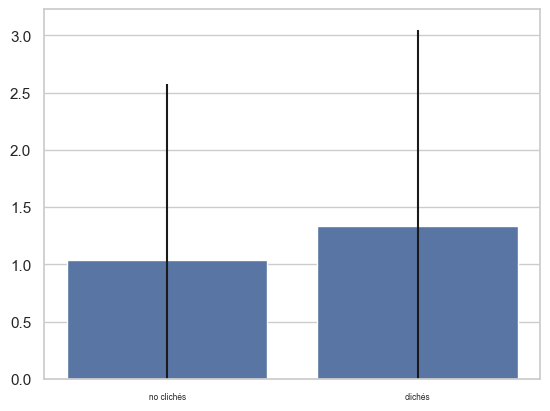

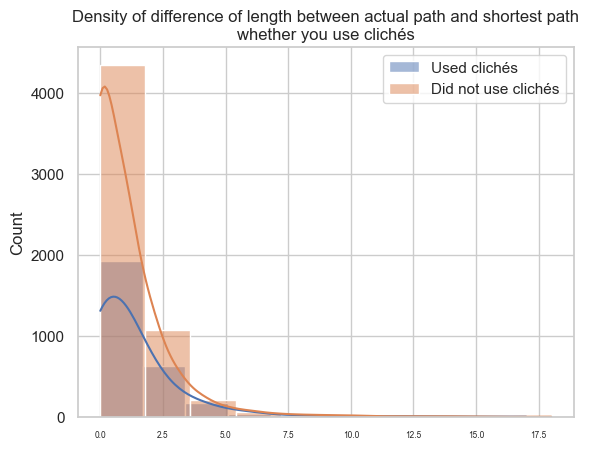

stat=8.182111772230817, pvalue=1.5953179008792737e-16
Result is significant at 0.05
Used clichés: (3072, 1)
Did not use clichés: (5704, 1)


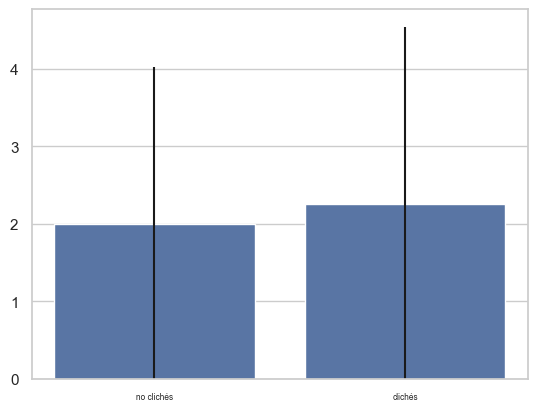

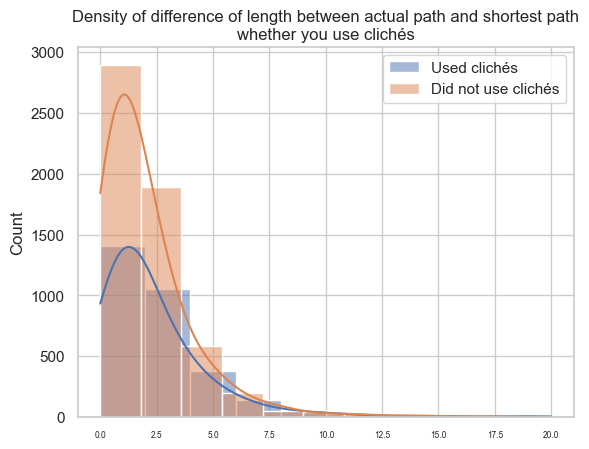

stat=5.668376638855656, pvalue=7.435889384866739e-09
Result is significant at 0.05
Used clichés: (2597, 1)
Did not use clichés: (4603, 1)


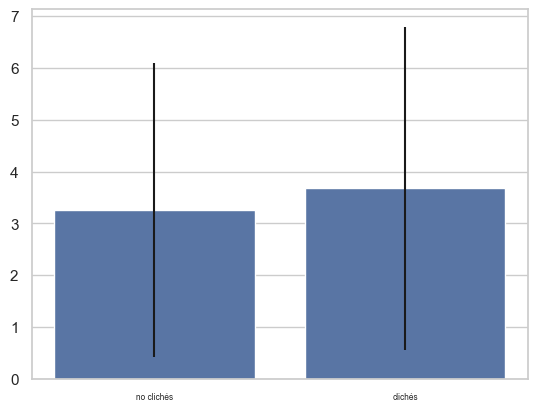

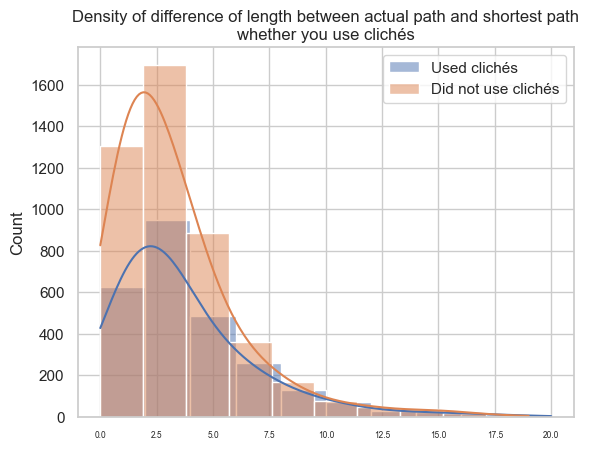

stat=5.896127147094906, pvalue=1.9447893002234724e-09
Result is significant at 0.05
Used clichés: (993, 1)
Did not use clichés: (1664, 1)


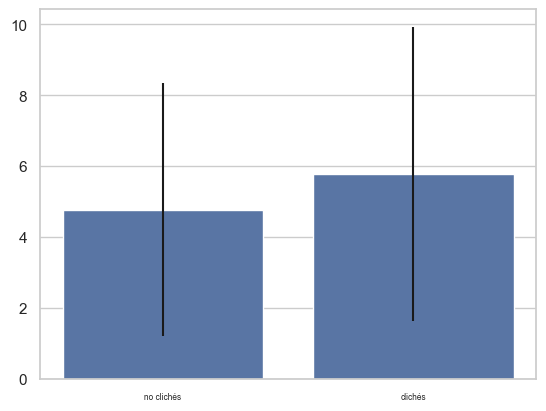

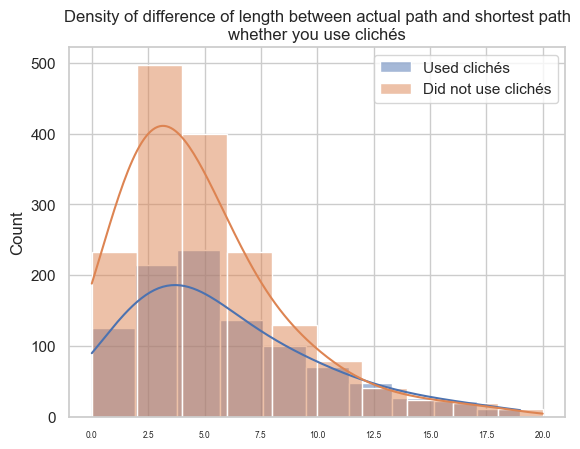

stat=6.645794436080173, pvalue=1.8231680882448125e-11
Result is significant at 0.05
Used clichés: (385, 1)
Did not use clichés: (649, 1)


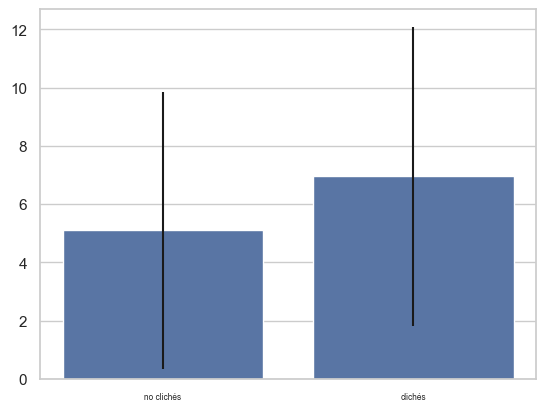

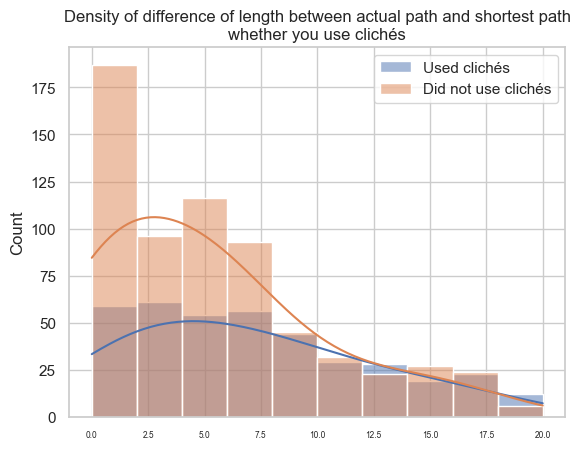

stat=5.874719985237277, pvalue=2.854486688314239e-09
Result is significant at 0.05


In [43]:
# do the statistical tests by rating by comparing difference of length for those using cliches and those who do not
from scipy import stats


def statistical_test(rating: int, df: pd.DataFrame, plot=False, verbose=False):
    """
    df: paths_finished_use_cliches
    """
    df_stats = (
        df.groupby(["rating", "uses_cliche"])[["diff_length"]]
        .apply(lambda x: x)
        .loc[rating]
    )

    went_through_cliche = df_stats.loc[True]
    didnot_go_through_cliche = df_stats.loc[False]
    # number of observations for each group
    print(f"Used clichés: {went_through_cliche.shape}")
    print(f"Did not use clichés: {didnot_go_through_cliche.shape}")

    # bar plot
    if plot:
        # plot mean of diff path length
        # plot standard deviation
        ax = sns.barplot(
            x=["no clichés", "clichés"],
            y=[df_stats.loc[id].values.mean() for id in df_stats.index.unique(0)],
        )
        x_coords = [p.get_x() + 0.5 * p.get_width() for p in ax.patches]
        y_coords = [p.get_height() for p in ax.patches]
        ax.errorbar(
            x=x_coords,
            y=y_coords,
            yerr=[df_stats.loc[id].values.std() for id in df_stats.index.unique(0)],
            fmt="none",
            c="k",
        )
        ax.set_ylim(0)
        plt.figure()

        # density of diff path length
        # cliché
        ax = sns.histplot(
            went_through_cliche.to_numpy().reshape(went_through_cliche.shape[0]),
            kde=True,
            bins=10,
            kde_kws={"bw_adjust": 2},
            label="Used clichés"
        )
        # no cliché
        ax = sns.histplot(
            didnot_go_through_cliche.to_numpy().reshape(didnot_go_through_cliche.shape[0]),
            kde=True,
            bins=10,
            kde_kws={"bw_adjust": 2},
            label="Did not use clichés"
        )
        ax.set_title("Density of difference of length between actual path and shortest path\nwhether you use clichés")
        plt.legend(loc="best")
        plt.show()

    # test if equal var for statistical test
    equal_var = False


    # rule of thumb is ratio <= 4
    if (
        np.amax([np.var(went_through_cliche.values), np.var(didnot_go_through_cliche.values)])
        / np.amin(
            [np.var(went_through_cliche.values), np.var(didnot_go_through_cliche.values)]
        )
        <= 4
    ):
        equal_var = True

    if verbose:
        print("Equal var:", equal_var == True)

    # statistical test
    stat, p = stats.ttest_ind(
        went_through_cliche.to_numpy().reshape(went_through_cliche.shape[0]),
        didnot_go_through_cliche.to_numpy().reshape(didnot_go_through_cliche.shape[0]),
        equal_var=equal_var,
        alternative="greater",
    )

    print(f"stat={stat}, pvalue={p}")
    print("Result is significant at 0.05" if p < 0.05 else "Result is not significant")

    return df_stats


for i in range(1, 6):
    statistical_test(i, paths_finished_use_cliche, True, False)

p-value smaller than 0.5. We reject null hypothesis